<a href="https://colab.research.google.com/github/boldasl/20_IT_SYSTEM_DESIGN_008/blob/master/HW2_%EA%B2%80%EC%A6%9D_2to1Mux_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Training 2to1 Mux using only numpy

import numpy as np
from math import exp
import matplotlib.pyplot as plt

from timeit import default_timer

In [0]:
class NeuralNetwork:
    activation = 0 # activation function
    variance = 0.1 # variance for weight initiation

    num_inputnode = 0 # the number of input node
    num_outputnode = 0 # the number of output node
    num_hiddenlayer = 0 # the number of hidden layer
    num_hiddennode = 0 # the number of hidden node

    w_inputnode = 0 # weight for input layer to hidden_0 layer
    w_hiddennode = 0 # weight for hidden_0 layer to hidden_n layer
    w_outputnode = 0 # weight for hidden_n layer to output layer

    b_hiddennode = 0 # bias for hidden layer
    b_outputnode = 0 # bias for output layer

    d_hiddennode = 0 # delta for hidden layer
    d_outputnode = 0 # delta for output layer

    o_hidden = 0 # output for hidden layer
    o_output = 0 # output for output layer

    data_train = 0 # training data
    label_train = 0 # training label
    data_test = 0 # test data

    error = 0 # cost function

    def __init__(self, inputnode, outputnode, hiddenlayer, hiddennode, act):
        self.num_inputnode = inputnode
        self.num_outputnode = outputnode
        self.num_hiddenlayer = hiddenlayer
        self.num_hiddennode = hiddennode
        self.activation = act

        # weight & bias init
        self.w_inputnode = np.random.normal(0, self.variance, size=[self.num_hiddennode, self.num_inputnode])
        if self.num_hiddenlayer > 1:
            self.w_hiddennode = np.random.normal(0, self.variance, size=[self.num_hiddenlayer-1, self.num_hiddennode, self.num_hiddennode])
        self.w_outputnode = np.random.normal(0, self.variance, size=[self.num_outputnode, self.num_hiddennode])

        self.b_hiddennode = np.random.normal(0, self.variance, size=[self.num_hiddenlayer, self.num_hiddennode])
        self.b_outputnode = np.random.normal(0, self.variance, size=self.num_outputnode)

        # delta init
        self.d_hiddennode = np.zeros([self.num_hiddenlayer, self.num_hiddennode])
        self.d_outputnode = np.zeros(self.num_outputnode)

        # output init
        self.o_hidden = np.zeros([self.num_hiddenlayer, self.num_hiddennode])
        self.o_output = np.zeros(self.num_outputnode)

        #np.random.seed(0) # seed

        print("< Neural Network Using Numpy >")
        print("# of InputNode  : {}   # of OutputNode: {}".format(self.num_inputnode, self.num_outputnode))
        print("# of HiddenLayer: {}   # of HiddenNode: {}".format(self.num_hiddenlayer, self.num_hiddennode))
        print("Activation Function: {}\n".format(self.activation))

    def input_dataset(self, train_data, train_label, test_data):
        self.data_train = train_data
        self.label_train = train_label
        self.data_test = test_data

    # actication function
    def func_act(self, a):
        len_a = len(a)
        if self.activation == "sigmoid":
            return np.array([1 / (1 + exp(-a[i])) for i in range(len_a)])
        elif self.activation == "relu":
            return np.array([a[i] if a[i] > 0 else 0 for i in range(len_a)])
        elif self.activation == "tanh":
            return np.array([np.tanh(a[i]) for i in range(len_a)])
        else: print("Error::NeuralNetwork.func_act;    Function Name")

    # actication function derivative
    def func_act_d(self, y):
        len_y = len(y)
        if self.activation == "sigmoid":
            return np.array([y[i]*(1-y[i]) for i in range(len_y)])
        elif self.activation == "relu":
            return np.array([1 if y[i] > 0 else 0 for i in range(len_y)])
        elif self.activation == "tanh":
            return np.array([(1-y[i])*(1+y[i]) for i in range(len_y)])
        else: print("Error::NeuralNetwork.func_act_d;    Function Name")

    # mean square error function
    def func_mse(self, y, y_h):
        return sum(abs(y-y_h))

    # mean square error functon derivative
    def func_mse_d(self, y, y_h):
        len_y = len(y)
        if len_y != len(y_h): print("Error:NeuralNetwork.func_mse_d;    Vector Length")
        return np.array([y[i]-y_h[i] for i in range(len_y)])

    def func_threshold(self, x):
        len_x = len(x)
        if self.activation == "tanh": result = [1 if x[i] > 0 else -1 for i in range(len_x)]
        else: result = [1 if x[i] > 0.5 else 0 for i in range(len_x)]

        return np.array(result)

    def perceptron(self, x, w, b):
        a = x @ w.T + b # w = [layer][node_after][node_before]
        return self.func_act(a)

    def feedforward(self, x):
        self.o_hidden[0] = self.perceptron(x, self.w_inputnode, self.b_hiddennode[0])
        if self.num_hiddenlayer > 1:
            for idx_layer in range(self.num_hiddenlayer-1):
                self.o_hidden[idx_layer+1] = self.perceptron(self.o_hidden[idx_layer], self.w_hiddennode[idx_layer], self.b_hiddennode[idx_layer+1])
        self.o_output = self.perceptron(self.o_hidden[self.num_hiddenlayer-1], self.w_outputnode, self.b_outputnode)
        return self.o_output

    def backpropagation(self, y, y_h):
        self.d_outputnode = self.func_act_d(y_h) * self.func_mse_d(y, y_h)

        if self.num_hiddenlayer > 1:
            self.d_hiddennode[self.num_hiddenlayer-1] = self.func_act_d(self.o_hidden[self.num_hiddenlayer-1]) * (self.d_outputnode @ self.w_outputnode)
            for idx_layer in range(self.num_hiddenlayer-2, -1, -1):
                self.d_hiddennode[idx_layer] = self.func_act_d(self.o_hidden[idx_layer]) * (self.d_hiddennode[idx_layer+1] @ self.w_hiddennode[idx_layer])
        else:
            self.d_hiddennode[0] = self.func_act_d(self.o_hidden[0]) * (self.d_outputnode @ self.w_outputnode)

    def learn(self, epoch, lr):
        print("Epoch: {}, Learning Rate: {}".format(epoch, lr))
        print("Learning Start!")
        self.error = []
        for idx_epoch in range(epoch):
            error_temp = 0
            for idx_test in range(self.data_test.shape[0]):
                expected = self.feedforward(self.data_train[idx_test])
                self.backpropagation(self.label_train[idx_test], expected)
                error_temp += self.func_mse(self.label_train[idx_test], expected)

                u_w_inputnode = np.outer(self.d_hiddennode[0], self.data_train[idx_test]) # update value
                self.w_inputnode = self.w_inputnode + lr * u_w_inputnode
                self.b_hiddennode[0] = self.b_hiddennode[0] + lr * self.d_hiddennode[0]

                if self.num_hiddenlayer > 1:
                    u_w_hiddennode = np.zeros(self.w_hiddennode.shape)
                    for idx_layer in range(self.num_hiddenlayer-1):
                        u_w_hiddennode[idx_layer] = np.outer(self.d_hiddennode[idx_layer+1], self.o_hidden[idx_layer]) # update value
                    u_w_outputnode = np.outer(self.d_outputnode, self.o_hidden[self.num_hiddenlayer-1]) # update value
                    self.w_hiddennode = self.w_hiddennode + lr * u_w_hiddennode
                else:
                    u_w_outputnode = np.outer(self.d_outputnode, self.o_hidden[0]) # update value

                self.w_outputnode = self.w_outputnode + lr * u_w_outputnode
                self.b_outputnode = self.b_outputnode + lr * self.d_outputnode
            self.error.append(error_temp / self.data_test.shape[0])
            if idx_epoch % 10 == 0:
                print("{0:0.1f}%, Cost = {1:0.4f}\r".format(idx_epoch/epoch*100, error_temp/self.data_test.shape[0]), end='')
        print("100.0%, Cost = {0:0.4f}".format(error_temp/self.data_test.shape[0]))

    def evaluation(self, repeat, variance):
        print("Evaluation Start!")
        accuracy = []
        for idx_repeat in range(repeat):
            test_input = self.data_test + np.random.normal(0, variance, size=self.data_test.shape)

            for idx_test in range(self.data_test.shape[0]):
                expected = self.func_threshold(self.feedforward(test_input[idx_test]))
                correct = self.label_train[idx_test]
                
                if sum(abs(expected - correct)) == 0: accuracy.append(1) # if this test case is correct
                else: accuracy.append(0) # if this test case isn't correct
        accuracy = np.average(accuracy) # average
        print("Accuracy: {0:0.4f}\t(test variance = {1})\n".format(accuracy, variance))

    def plot(self):
        epoch = len(self.error)
        plt.plot(range(epoch), self.error)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.xlim(0, epoch)
        plt.ylim(0, 1.2)
        plt.show()

In [0]:
# learning configuration
LearningRate = 0.1
Epoch = 1000
Activation = "tanh"
NumInputNode = 3
NumOutputNode = 1
NumHiddenLayer = 1
NumHiddenNode = 3

# train data set: 2to1 Mux
# train_data = [select, in_1, in_0]
# train_label = [out]
train_data = [[-1, -1, -1], [-1, -1, 1], [-1, 1, -1], [-1, 1, 1], [1, -1, -1], [1, -1, 1], [1, 1, -1], [1, 1, 1]] 
train_label = [[-1], [1], [-1], [1], [-1], [-1], [1], [1]] 

train_data = np.array(train_data)
train_label = np.array(train_label)


< Neural Network Using Numpy >
# of InputNode  : 3   # of OutputNode: 1
# of HiddenLayer: 1   # of HiddenNode: 3
Activation Function: tanh

Epoch: 1000, Learning Rate: 0.1
Learning Start!
100.0%, Cost = 0.0171
Training Time = 1.45[s]

Evaluation Start!
Accuracy: 1.0000	(test variance = 0.1)



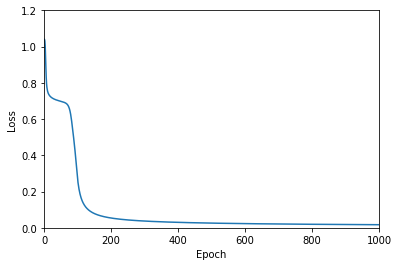

In [4]:
model = NeuralNetwork(NumInputNode, NumOutputNode, NumHiddenLayer, NumHiddenNode, Activation)
model.input_dataset(train_data, train_label, train_data) # training data, training label, test data

before = default_timer()
model.learn(epoch=Epoch, lr=LearningRate)
print("Training Time = {0:0.2f}[s]\n".format(default_timer()-before))
model.evaluation(repeat=100, variance=0.1)
model.plot()
